# XXZ300: data generation

## Init

### Imports & config

In [1]:
import classifim.bench.fidelity
import classifim.bench.metric
import classifim.bench.peaks
import classifim.bench.plot_tools
import classifim.utils
import classifim_gen.gs_cache
import classifim_gen.gs_utils
import classifim_gen.io
import classifim_gen.xxz
import functools
import glob
import h5py
import itertools
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import re
import scipy.sparse.linalg
import sys
import warnings

from tqdm import tqdm, trange

The following settings were used to generate the images for the main paper. They can be commented out (the cell made "raw" using CTRL+R, use CTRL+Y to make it "code") since they require a LaTeX installation with some fonts and packages used by matplotlib.

In [2]:
# [Optional]: matplotlib.backend_bases.register_backend('pgf', FigureCanvasPgf)
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
HAM_NAME = "XXZ300"
DATA_DIR0 = classifim.utils.find_data_dir()
assert os.path.isdir(DATA_DIR0)
DATA_DIR = classifim.utils.maybe_create_subdir(DATA_DIR0, "xxz_300")

HF_DATA_DIR0 = classifim.utils.find_data_dir("hf_data_dir")
HF_DATA_DIR = os.path.join(HF_DATA_DIR0, "xxz_300_z")

In [4]:
class XxzParamConversions:
    lambda_grid_size = (64, 64)
    
    @staticmethod
    def lambdas_to_params(lambda0, lambda1):
        """
        Convert between lambdas (in range [0, 1]) to params (J' and delta).
        """
        return lambda0 * 2.5, lambda1 * 3.5

    @staticmethod
    def params_to_lambdas(Jprime, delta):
        return Jprime / 2.5, delta / 3.5

    @classmethod
    def lambdais_to_lambdas(cls, lambda0i, lambda1i):
        """
        Convert indices to lambdas.
        """
        d0, d1 = [s - 1 for s in cls.lambda_grid_size]
        return (lambda0i / d0, lambda1i / d1)

    @functools.cached_property
    def all_Jprimes(self):
        size = self.lambda_grid_size[0]
        return 2.5 * np.arange(size) / (size - 1)

    @functools.cached_property
    def all_deltas(self):
        size = self.lambda_grid_size[1]
        return 2.5 * np.arange(size) / (size - 1)
    
param_conversions = XxzParamConversions()

## Data generation / reshaping

DMRG is used to generate the samples and inner products between ground states.
The DMRG code is located in "hpc/dmrgpy_xxz_getmps.{slurm,py}" and not produced by this notebook.

### Extract datasets and inner products

* Requires: DMRG results in "samples" directory.
* Generates: classifim_datasets

In [7]:
SAMPLES_DIR = os.path.join(DATA_DIR, "samples")
SAMPLES_FILE_PATTERN = os.path.join(
    SAMPLES_DIR, "dmrgpy_out_{seed:02d}_{lambda0i}_{lambda1i}.hdf5")

In [8]:
def read_h5py_colmaj(h5py_dataset):
    res = h5py_dataset[()]
    if isinstance(res, np.ndarray) and res.ndim > 1:
        res = np.transpose(res, axes=tuple(reversed(range(res.ndim))))
    return res

def _read_sample_file(
        samples_data, f, seed_i, lambda0i, lambda1i, all_seeds, read_samples):
    seed = all_seeds[seed_i]
    assert lambda0i == f["lambda0i"][()]
    assert lambda1i == f["lambda1i"][()]
    lambda_is = (lambda0i, lambda1i)
    if read_samples:
        for key in ["z_samples", "pauli_samples"]:
            samples_data[key][seed_i, lambda0i, lambda1i, :, :] = (
                read_h5py_colmaj(f[key]))
    for key in ["level_overlap", "time"]:
        samples_data[key][seed_i, lambda0i, lambda1i] = f[key][()]
    for key in ["time_estimate", "num_cpu_cores", "input_size"]:
        if key in f.keys():
            samples_data[key][seed_i, lambda0i, lambda1i] = f[key][()]
    if seed_i < len(all_seeds) - 1:
        assert f['seed_overlap.key'][()] == all_seeds[seed_i + 1]
        samples_data["seed_overlap"][seed_i, lambda0i, lambda1i, :, :] = (
            read_h5py_colmaj(f["seed_overlap.value"]))
    else:
        assert 'seed_overlap.key' not in f.keys()
    lo_keys = read_h5py_colmaj(f["lambda_overlap.keys"])
    lo_values = read_h5py_colmaj(f["lambda_overlap.values"])
    for other_lambda_is, lo_value in zip(lo_keys, lo_values):
        ldir = tuple(np.subtract(other_lambda_is, lambda_is))
        try:
            samples_data["lambda_overlap"][ldir][
                seed_i,
                lambda0i + min(ldir[0], 0),
                lambda1i + min(ldir[1], 0),
                :, :] = lo_value
        except IndexError:
            warnings.warn(
                f"Unexpected dir={ldir} for {lambda_is=}: {other_lambda_is=}; "
                + f"target shape={samples_data['lambda_overlap'][ldir].shape}.")
            # Note: this is a known issue, we need to regenerate the data.

def read_sample_data(
        file_pattern, lambda_grid_size=XxzParamConversions.lambda_grid_size,
        num_samples=1400, num_sites=300, all_seeds=[3, 4], num_levels=2,
        read_samples=True):
    num_seeds = len(all_seeds)
    samples_data = {
        "seed_overlap": np.empty(
            dtype=np.float64,
            shape=(num_seeds-1,) + lambda_grid_size + (num_levels,) * 2),
        "time_estimate": np.full(
            fill_value=np.nan, dtype=np.float64,
            shape=(num_seeds,) + lambda_grid_size),
        "lambda_overlap": {
            ldir: np.full(
                fill_value=np.nan,
                dtype=np.float64,
                shape=(
                    (2,) + tuple(np.subtract(lambda_grid_size, np.abs(ldir)))
                    + (num_levels,) * 2))
            for ldir in [(0, 1), (1, 0), (1, 1), (1, -1)]
        }}
    if read_samples:
        for key in ["z_samples", "pauli_samples"]:
            samples_data[key] = np.empty(
                dtype=np.int8,
                shape=(num_seeds,) + lambda_grid_size + (num_samples, num_sites))
    for key in ["num_cpu_cores", "input_size", "time"]:
        samples_data[key] = np.full(
            fill_value=-1, dtype=np.int64,
            shape=(num_seeds,) + lambda_grid_size)
    for key in ["level_overlap", "time"]:
        samples_data[key] = np.empty(
            dtype=np.float64, shape=(num_seeds,) + lambda_grid_size)
    all_idx_sizes = (num_seeds,) + lambda_grid_size
    all_idxs = itertools.product(*[range(s) for s in all_idx_sizes])
    for seed_i, lambda0i, lambda1i in tqdm(
            all_idxs, total=np.prod(all_idx_sizes)):
        seed = all_seeds[seed_i]
        file_name = file_pattern.format(seed=seed, lambda0i=lambda0i, lambda1i=lambda1i)
        with h5py.File(file_name, 'r') as f:
            _read_sample_file(
                samples_data, f, seed_i, lambda0i, lambda1i, all_seeds,
                read_samples=read_samples)
    samples_data["all_seeds"] = all_seeds
    return samples_data


In [9]:
samples_data = read_sample_data(
    file_pattern=SAMPLES_FILE_PATTERN, read_samples=False)

  0%|                                                                                                          | 0/8192 [00:00<?, ?it/s]


KeyError: "Unable to synchronously open object (object 'level_overlap' doesn't exist)"

In [73]:
def pretty_print(data, prefix=""):
    for key, value in data.items():
        print(f"{prefix}{key}: ", end="")
        if isinstance(value, np.ndarray):
            print(f"{value.dtype} {value.shape}")
        elif isinstance(value, dict):
            print("")
            pretty_print(value, prefix=prefix + "  ")
        else:
            print(f"{value}")
pretty_print(samples_data)

seed_overlap: float64 (1, 64, 64, 2, 2)
time_estimate: float64 (2, 64, 64)
lambda_overlap: 
  (0, 1): float64 (2, 64, 63, 2, 2)
  (1, 0): float64 (2, 63, 64, 2, 2)
  (1, 1): float64 (2, 63, 63, 2, 2)
z_samples: int8 (2, 64, 64, 1400, 300)
pauli_samples: int8 (2, 64, 64, 1400, 300)
num_cpu_cores: int64 (2, 64, 64)
input_size: int64 (2, 64, 64)
time: float64 (2, 64, 64)
level_overlap: float64 (2, 64, 64)


### Generate datasets

* Requires: Loaded `samples_data` (see above).
* Generates: `classifim_datasets`

In [10]:
def generate_dataset(seed, samples, lambdais_to_lambdas):
    num_lambda0, num_lambda1, size_per_lambda, n_sites = samples.shape
    num_samples = num_lambda0 * num_lambda1 * size_per_lambda
    lambda_is = np.mgrid[0:num_lambda0, 0:num_lambda1]
    lambdas = np.array(lambdais_to_lambdas(
        *lambda_is.reshape(2, num_lambda0 * num_lambda1))).T
    lambdas = lambdas.repeat(size_per_lambda, axis=0)
    zs = samples.reshape((num_samples, n_sites))
    
    rng = np.random.default_rng(seed)
    permutation = rng.permutation(num_samples)
    lambdas = lambdas[permutation]
    zs = zs[permutation]

    return {
        "lambdas": lambdas,
        "zs": zs,
        "size_per_lambda": size_per_lambda,
        "seed": seed,
        "packed": False
    }

In [40]:
%%time
CLASSIFIM_DATASET_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "classifim_datasets")
size_per_lambda = 140
for sample_type in ("z", "pauli"):
    for seed in range(5, 16):
        seed_i = (seed + 1) % 2
        istart = ((seed - 5) // 2) * size_per_lambda
        iend = istart + size_per_lambda
        cur_samples = samples_data[sample_type + "_samples"][seed_i, :, :, istart:iend, :]
        cur_dataset = generate_dataset(seed, cur_samples, param_conversions.lambdais_to_lambdas)
        cur_dataset["sample_type"] = sample_type
        dataset_filename = os.path.join(CLASSIFIM_DATASET_DIR, f"dataset_{sample_type}_{seed}.npz")
        np.savez_compressed(dataset_filename, **cur_dataset)
        print(f"Dataset is saved to '{dataset_filename}'")

  9%|█████████████                                                                                                                                   | 1/11 [00:11<01:54, 11.45s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_5.npz'


 18%|██████████████████████████▏                                                                                                                     | 2/11 [00:22<01:42, 11.37s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_6.npz'


 27%|███████████████████████████████████████▎                                                                                                        | 3/11 [00:33<01:30, 11.31s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_7.npz'


 36%|████████████████████████████████████████████████████▎                                                                                           | 4/11 [00:45<01:19, 11.34s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_8.npz'


 45%|█████████████████████████████████████████████████████████████████▍                                                                              | 5/11 [00:56<01:08, 11.34s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_9.npz'


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 6/11 [01:08<00:56, 11.32s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_10.npz'


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 7/11 [01:19<00:45, 11.31s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_11.npz'


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 8/11 [01:30<00:33, 11.30s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_12.npz'


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 9/11 [01:41<00:22, 11.29s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_13.npz'


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 10/11 [01:53<00:11, 11.28s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_14.npz'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:04<00:00, 11.31s/it]


Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_z_15.npz'


  9%|█████████████                                                                                                                                   | 1/11 [00:32<05:29, 32.91s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_5.npz'


 18%|██████████████████████████▏                                                                                                                     | 2/11 [01:05<04:56, 32.89s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_6.npz'


 27%|███████████████████████████████████████▎                                                                                                        | 3/11 [01:38<04:23, 32.92s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_7.npz'


 36%|████████████████████████████████████████████████████▎                                                                                           | 4/11 [02:11<03:50, 32.86s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_8.npz'


 45%|█████████████████████████████████████████████████████████████████▍                                                                              | 5/11 [02:44<03:17, 32.86s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_9.npz'


 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 6/11 [03:16<02:43, 32.77s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_10.npz'


 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 7/11 [03:49<02:10, 32.74s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_11.npz'


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 8/11 [04:22<01:38, 32.86s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_12.npz'


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 9/11 [04:55<01:05, 32.97s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_13.npz'


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 10/11 [05:28<00:32, 32.97s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_14.npz'


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [06:02<00:00, 32.92s/it]

Dataset is saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/classifim_datasets/dataset_pauli_15.npz'


### Compute ground truth FIM

* Requires: Loaded `samples_data` (see above).
* Generates: ground truth FIM (`fim/gs_fim_3.npz`)

In [35]:
FIM_DIR = classifim.utils.maybe_create_subdir(DATA_DIR, "fim")
gs_fims = {}
gs_fims_npz = {}

for seed_i, seed in enumerate(samples_data["all_seeds"]):
    cur_fidelities = {
        k: np.abs(v[seed_i, :, :, 0, 0])
        for k, v in samples_data["lambda_overlap"].items()}
    cur_fim = classifim.bench.fidelity.compute_2d_fim_from_fidelities(
        cur_fidelities, resolution=64, denominator_resolution=63)
    cur_fim_npz = classifim.bench.fidelity.encode_for_npz(cur_fim)
    cur_fim_npz["seed"] = seed
    gs_fims[seed] = cur_fim
    gs_fims_npz[seed] = cur_fim_npz
    filename = os.path.join(FIM_DIR, f"gs_fim_{seed}.npz")
    np.savez_compressed(filename, **cur_fim_npz)
    print(f"gs_fims[{seed}] saved to '{filename}'")

gs_fims[3] saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/fim/gs_fim_3.npz'
gs_fims[4] saved to '/media/victor/ssd_T7_Victor/d/qc4ml/bschifc_data/neurips2023/xxz1d/fim/gs_fim_4.npz'


### Level overlap

This is a bug with our use of excited state DMRG, but since we only care about ground state, it is not worth re-running (i.e. the bug does not affect the results reported in the paper).

In [84]:
def plot_level_overlap(
        samples_data, savefig_to=None, plot_triangle=False, take_abs=False):
    fig = plt.figure(figsize=(16, 5.0), constrained_layout=True)
    gs = matplotlib.gridspec.GridSpec(
        1, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], figure=fig)
    ax0, ax1, ax2 = axs = [fig.add_subplot(gs[0, i]) for i in [0, 2, 4]]
    cbar_ax0, cbar_ax1, cbar_ax2 = cbar_axs = [
        fig.add_subplot(gs[0, i]) for i in [1, 3, 5]]

    cmap = classifim.bench.plot_tools.spiral_background2_cmap
    kwargs = {"cmap": cmap, "shading": "nearest", "vmin": -1, "vmax": 1}
    level_overlap = samples_data["level_overlap"]
    seed_overlap = samples_data["seed_overlap"][0, :, :, 0, 0]
    if take_abs:
        level_overlap = np.abs(level_overlap)
        seed_overlap = np.abs(seed_overlap)
        kwargs["vmin"] = 0
    Jprimes = param_conversions.all_Jprimes
    deltas = param_conversions.all_deltas
    for seed_i, (ax, cbar_ax) in enumerate(zip(axs[:2], cbar_axs[:2])):
        pc_i = ax.pcolormesh(
            Jprimes, deltas,
            level_overlap[seed_i, :, :].T,
            **kwargs)
        fig.colorbar(pc_i, cax=cbar_ax)
        ax.set_title(r"$\left<\psi_0 | \psi_1\right>$ " + f"\\#{seed_i}")

    pc2 = ax2.pcolormesh(Jprimes, deltas, seed_overlap.T, **kwargs)
    ax2.set_title(r"$\left<\psi_0\#0 | \psi_0\#1\right>$")
    cbar2 = fig.colorbar(pc2, cax=cbar_ax2)

    if plot_triangle:
        for ax in axs:
            plot_xxz_triangle(ax)
    
    ax0.set_ylabel("$\delta$")
    for ax in axs:
        ax.set_xlabel("$J'$")
    
    if savefig_to is not None:
        fig.savefig(savefig_to, bbox_inches="tight", dpi=600)
        print(f"Saved fig to '{savefig_to}'.")

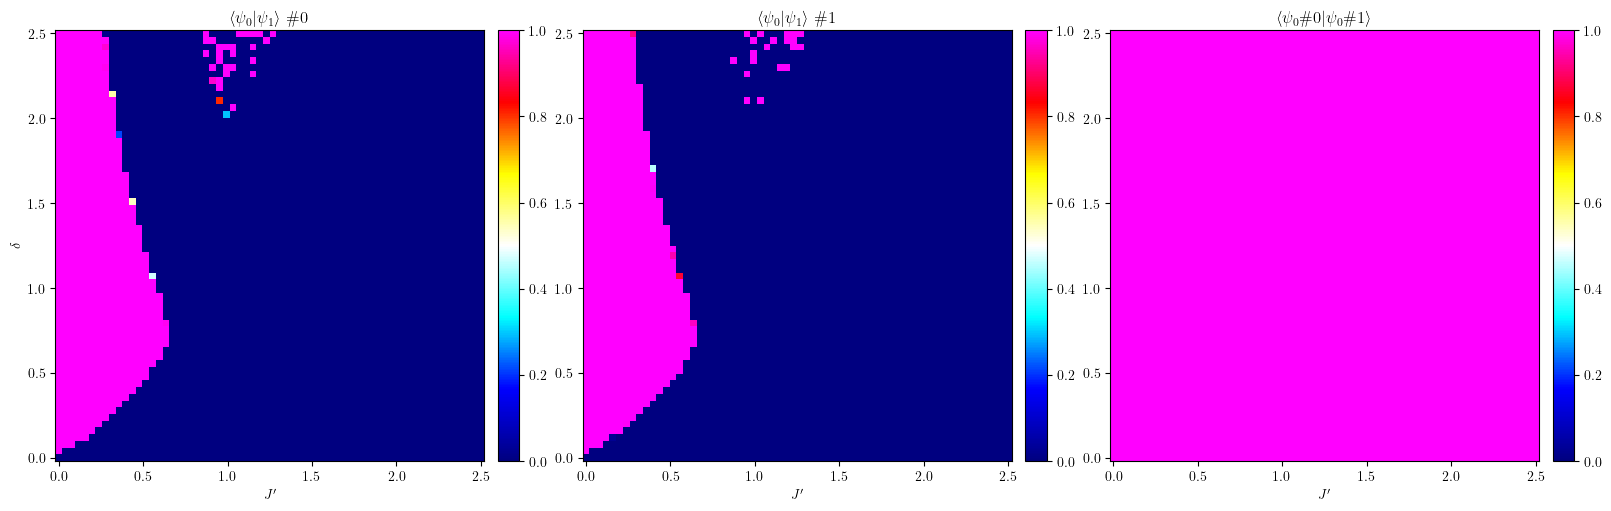

In [86]:
plot_level_overlap(samples_data, take_abs=True)

## Convert to parquet

In [26]:
data_seeds = classifim_gen.io.save_datasets_for_hf(
    convert_f=classifim_gen.xxz.convert_dataset_to_hf,
    input_pattern=os.path.join(DATA_DIR, "classifim_datasets", "dataset_z_{seed}.npz"),
    output_dir=HF_DATA_DIR,
    overwrite=False)
print("Done.")

Skipping seed 12: output files already exist.
Skipping seed 13: output files already exist.
Skipping seed 5: output files already exist.
Skipping seed 15: output files already exist.
Skipping seed 6: output files already exist.
Skipping seed 9: output files already exist.
Skipping seed 11: output files already exist.
Skipping seed 7: output files already exist.
Skipping seed 14: output files already exist.
Skipping seed 10: output files already exist.
Skipping seed 8: output files already exist.
Done.


In [6]:
for seed in [3, 4]:
    with np.load(os.path.join(DATA_DIR, "fim", f"gs_fim_{seed}.npz")) as f:
        fim_npz = dict(f)
    try:
        del fim_npz["seed"]
    except KeyError:
        pass
    gt_fim_filename = os.path.join(
        classifim.utils.maybe_create_subdir(HF_DATA_DIR, f"seed_{seed:02d}"),
        "gt_fim.parquet")
    pq.write_table(pa.Table.from_pydict(fim_npz), gt_fim_filename)

In [31]:
import importlib
importlib.reload(classifim_gen.io)
print(classifim_gen.io.gen_config_yml(
    sm_name=os.path.basename(HF_DATA_DIR),
    seeds=sorted(data_seeds),
    fim_seeds=[3,4]))

- config_name: xxz_300_z.seed03.gt_fim
  data_files:
  - split: test
    path: xxz_300_z/seed_03/gt_fim.parquet
- config_name: xxz_300_z.seed04.gt_fim
  data_files:
  - split: test
    path: xxz_300_z/seed_04/gt_fim.parquet
- config_name: xxz_300_z.seed05
  data_files:
  - split: train
    path: xxz_300_z/seed_05/d_train.parquet
  - split: test
    path: xxz_300_z/seed_05/d_test.parquet
- config_name: xxz_300_z.seed06
  data_files:
  - split: train
    path: xxz_300_z/seed_06/d_train.parquet
  - split: test
    path: xxz_300_z/seed_06/d_test.parquet
- config_name: xxz_300_z.seed07
  data_files:
  - split: train
    path: xxz_300_z/seed_07/d_train.parquet
  - split: test
    path: xxz_300_z/seed_07/d_test.parquet
- config_name: xxz_300_z.seed08
  data_files:
  - split: train
    path: xxz_300_z/seed_08/d_train.parquet
  - split: test
    path: xxz_300_z/seed_08/d_test.parquet
- config_name: xxz_300_z.seed09
  data_files:
  - split: train
    path: xxz_300_z/seed_09/d_train.parquet
  - s

## Scratch

In [8]:
print("""
    test quote
    a""")


    test quote
    a


In [9]:
def trim_multiline(s):
    """
    Trim a multiline string.

    This removes:
    - leading and trailing whitespace
    - indentation common to all non-empty lines.
    """
    ... # TODO: implement

# Test:
assert trim_multiline(trim_multiline.__doc__) == """Trim a multiline string.

This removes:
- leading and trailing whitespace
- indentation common to all non-empty lines."""

AssertionError: 

In [18]:
def trim_multiline(s):
    """
    Trim a multiline string.

    This removes:
    - leading whitespace-only lines,
    - trailing whitespace,
    - indentation common to all non-empty lines.
    """
    # Step 1: remove trailing whitespace and split into lines:
    lines = s.rstrip().splitlines()
    min_indent = float('inf')

    # Step 2: Remove leading whitespace
    num_empty = len(lines)
    for i, line in enumerate(lines):
        if line.strip():
            num_empty = i
            break

    # Step 3: Find the common indentation
    for line in lines[num_empty:]:
        stripped_line = line.lstrip()
        if stripped_line:
            indent = len(line) - len(stripped_line)
            min_indent = min(min_indent, indent)

    # Step 4: Join and return
    return '\n'.join(line[min_indent:] for line in lines[num_empty:])

In [19]:
res = trim_multiline(trim_multiline.__doc__)
print(res)

Trim a multiline string.

This removes:
- leading whitespace-only lines,
- trailing whitespace,
- indentation common to all non-empty lines.
